In [65]:
# import packages
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
import shap
import EDA_part2
import Prep_data_UL_V2

In [ ]:
def clean_data(input_df: pd.DataFrame, remove_cols: list[str], y_col: list[str]) -> pd.DataFrame:
  """
  This function prepares the dataframe for unsupervised learning by removing unwanted columns
  and splitting the data into train and test sets.

  INPUTS:
  input_df: a pandas dataframe object of the combined charging data
  remove_cols: a list of columns to remove from the dataset (not relavent to our study)
  y_col: a string entry title for the column that we're performing unsupervised learning on

  OUTPUTS:
  output_df: a pandas dataframe object of the cleaned and standardized data
  """

  # First remove columns unwanted:
  temp_df = input_df.drop(columns=remove_cols)

  # Make subset df that does not include the target column(s)
  if isinstance(y_col, list):
      features_df = temp_df.drop(columns=y_col)
      target_df = temp_df[y_col]
  else:
      features_df = temp_df.drop(columns=[y_col])
      target_df = temp_df[[y_col]]

  # Separate test data from train/val set:
  X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=42)

  return X_train, X_test, y_train, y_test

def get_data(num_sample: int = 5000) -> dict[pd.DataFrame]:
  """
  This function reads in the data, merges the data, processes
  the datetime, and maps the anomalies.

  INPUTS:
  num_sample: the number of samples to pull from the dataset

  OUTPUTS:
  dataframes: a dictionary of the train and test dataframes
  """

  print("reading data")
  merged_df = EDA_part2.combine_charging_data(input_condition=2)
  print("data combined")
  merged_time_df = Prep_data_UL_V2.process_datetime(merged_df)
  print("datetime processed")
  mapped_df = Prep_data_UL_V2.anomaly_tags(merged_time_df, anomaly_list=None)
  print("anomalies mapped")
  len_before = len(mapped_df)
  mapped_df = mapped_df.dropna()
  print(f"dropped {len_before - len(mapped_df)} rows with NaN values")

  # Declare the target and unwanted columns:
  y_col = "flag_id"
  remove_cols = ["session_id", "connector_id_x", "evse_id", "connector_id_y", "start_datetime", "end_datetime",
                  "hour", "minute", "second"]

  # Get the train, val, and test split of data
  print("cleaning data")
  cleaned_data = clean_data(mapped_df, remove_cols=remove_cols, y_col=y_col)
  print("data cleaned")

  df_names = ["X_train", "X_test", "y_train", "y_test"]
  dataframes = dict(zip(df_names, [df.sample(num_sample) for df in cleaned_data]))

  return dataframes # X_train, X_test, y_train, y_test


def drop_columns(input_data: dict[pd.DataFrame]) -> list[pd.DataFrame]:
  """
  This function drops the columns that are not needed for the unsupervised learning model.

  INPUTS:
  input_data: a dictionary of the train and test dataframes

  OUTPUTS:
  output_data: a list of the train and test dataframes with the columns dropped
  """

  cat_cols = ["power_kw", "connector_type", "pricing", "region", "land_use", "metro_area", "charge_level", "venue"]
  non_unique_cal = ["num_ports", "connector_number"]
  output_data = []
  # drop columns
  for key, data in input_data.items():
    if "X" in key:
      output_data.append(data.drop(columns=(cat_cols + non_unique_cal)))
    else:
      output_data.append(data)
  return output_data

def train_isf(X_train: pd.DataFrame) -> IsolationForest:
  # train isolation forest
  isf = IsolationForest(n_estimators=100,
                          max_samples=1000,
                          n_jobs=-1,
                          random_state=42
                          )
  isf.fit(X_train)
  return isf

def train_lof(X_train: pd.DataFrame) -> LocalOutlierFactor:
  # train LOF
  lof = LocalOutlierFactor(novelty=True)
  lof.fit(X_train)
  return lof

def display_shap_plot_ISF(ISF: IsolationForest, X_train: pd.DataFrame, X_test: pd.DataFrame):
  """
  This function displays the SHAP plot for the Isolation Forest model.

  INPUTS:
  ISF: the Isolation Forest model
  X_train: the training data
  X_test: the test data

  OUTPUTS:
  Displays the SHAP plot
  """

  explainer_ISF = shap.TreeExplainer(ISF)
  shap_values_ISF = explainer_ISF.shap_values(X_test)
  shap_values_ordered = shap_values_ISF[:, np.argsort(X_train.columns)]
  shap.summary_plot(shap_values_ordered, X_test, feature_names=X_train.columns)

def display_shap_plot_LOF(LOF: LocalOutlierFactor, X_train: pd.DataFrame, X_test: pd.DataFrame, num_of_train_samples: int = 50, num_of_test_samples: int = 2000):
  """
  This function displays the SHAP plot for the Local Outlier Factor model.

  INPUTS:
  LOF: the Local Outlier Factor model
  X_train: the training data
  X_test: the test data
  num_of_train_samples: the number of training samples to use
  num_of_test_samples: the number of test samples to use

  OUTPUTS:
  Displays the SHAP plot

  NOTE: The .decision_function(X) in LOF returns negative values, where
  lower scores indicate more anomalous points. LOF scores are typically
  negative, and more negative values indicate stronger anomalies.
  Therefore, we use the negative of the LOF scores to get the SHAP values.

  """
  explainer_LOF = shap.KernelExplainer(lambda X: -LOF.decision_function(X), X_train[:num_of_train_samples])  # Use a small subset of training data as the background
  shap_values_LOF = explainer_LOF.shap_values(X_test[:num_of_test_samples])
  shap_values_ordered = shap_values_LOF[:, np.argsort(X_train.columns)]
  shap.summary_plot(shap_values_ordered, X_test[:num_of_test_samples], feature_names=X_train.columns)


In [68]:
X_train, X_test, y_train, y_test = drop_columns(get_data())

reading data
data combined
datetime processed
anomalies mapped
dropped 15578 rows with NaN values
cleaning data
data cleaned


In [69]:
ISF = train_isf(X_train)
LOF = train_lof(X_train)

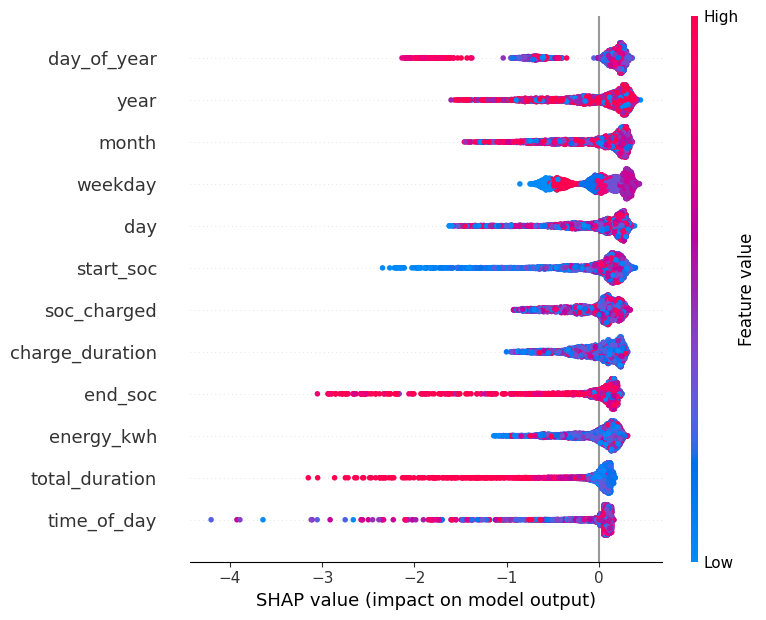

In [71]:
display_shap_plot_ISF(ISF, X_train, X_test)

/Users/zymoncone/github/milestone_ii/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/zymoncone/github/milestone_ii/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/zymoncone/github/milestone_ii/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/zymoncone/github/milestone_ii/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/zymoncone/github/milestone_ii/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/zymoncone/github/milestone_ii/.venv/lib/python3.13/site-packages/sklearn/utils/validation

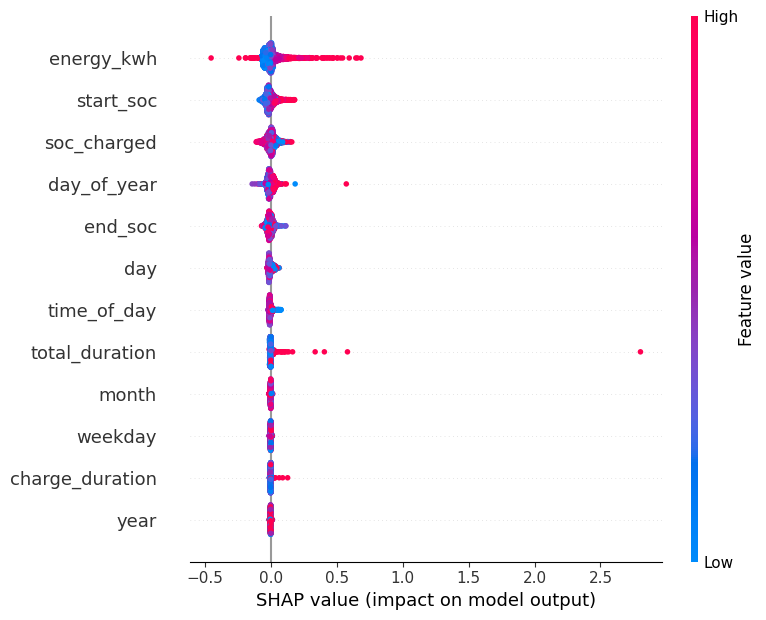

In [ ]:
display_shap_plot_LOF(LOF, X_train, X_test)